# Intro to Regression

We're going to go through a few regression exercises that will help you better see how regression might work in action in Python.  

## Learning Goals
The packages and techniques we'll hope to get comfortable with in this activity are the following:
- [***statsmodels***](http://statsmodels.sourceforge.net/): a package mainly best at doing regressions with traditional R formula syntax
- [***R formulas***](http://science.nature.nps.gov/im/datamgmt/statistics/r/formulas/): R formulas are a convenient way for encapsulating functional relationships for regressions
- [***seaborn***](http://stanford.edu/~mwaskom/software/seaborn/): We'll use seaborn for **visualization** as we go along
- [***scikit-learn***](http://scikit-learn.org/dev/index.html): This is the main machine learning package we'll be using throughout the course.  It has a multitude of machine learning algorithms and helpful machine learning pipeline tools.  sklearn has a tremendous amount of functionality, to get the most out of this course it will help to really explore the depth of the documentation on your own and watch as you understand more and more of the functionality as the course progresses.
- [***Linear Regression***](http://scikit-learn.org/stable/modules/linear_model.html) with scikit-learn:  We'll work with the basic linear regression module(s)
- [***Variable Preprocessing and Polynomial Regression***](http://scikit-learn.org/dev/modules/preprocessing.html#preprocessing) with scikit-learn:  We'll be **"standardizing"** or **"normalizing"** many of our variables to yield better model data.  We'll show how the "linear" models can be extended to basically any type of function by using functions of the different fields as the inputs to the linear model.
- [***Regularization and Cross-Validation***](http://scikit-learn.org/dev/model_selection.html#model-selection): The most important takeaway from today, this is how you know if your model will **generalize** to real-world data and how you evaluate the success of your model.

## Datasets
We'll take a look at a few different datasets:
1. [Survey Responses](http://www.ats.ucla.edu/stat/examples/chp/p054.txt) 
2. Manufactured random dataset  
3. [Bike sharing dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

## Setup
Try running the following imports and check that they all import successfully.  If they do not, the commands for the installs are given below.  If necessary, at a command line window run the ones that are failing for you and then retry the imports.

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV
%matplotlib inline

### Installations (if necessary)
<pre><code>conda install pandas</code></pre>
<pre><code>conda install numpy</code></pre>
<pre><code>conda install statsmodels</code></pre>
<pre><code>conda install seaborn</code></pre>
<pre><code>conda install scikit-learn</code></pre>

## Survey Data
We will use this [simple survey data](http://www.ats.ucla.edu/stat/examples/chp/p054.txt) to demonstrate a few basic features of ***statsmodels*** and ***seaborn*** and how they might be used in a data science workflow for regression.

The dataset is simply the results of a survey where the question responses are all numeric.  This leads to 6 numeric independent variable (predictor) fields and 1 numeric dependent variable (response) field.  The predictors are labeled ***X<sub>i</sub>*** and the response is labeled ***Y***.

Let's load the dataset in using ***pandas*** and take a look at it.  Here we use [***pandas.read_table***](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html) to load the data.

In [2]:
# Load the data in
df = pd.read_table('http://www.ats.ucla.edu/stat/examples/chp/p054.txt')
# Take a look at the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 7 columns):
Y      30 non-null int64
X1     30 non-null int64
X2     30 non-null int64
X3     30 non-null int64
X4     30 non-null int64
X5     30 non-null int64
X6     30 non-null int64
dtypes: int64(7)
memory usage: 1.9 KB


In [3]:
# Take a look at the first few rows
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,43,51,30,39,61,92,45
1,63,64,51,54,63,73,47
2,71,70,68,69,76,86,48
3,61,63,45,47,54,84,35
4,81,78,56,66,71,83,47


If we look at the column names, we'll notice we have the trailing whitespace problem again.

In [4]:
df.columns

Index([u'Y ', u'X1 ', u'X2 ', u'X3 ', u'X4 ', u'X5 ', u'X6 '], dtype='object')

We can remove this by calling map on the columns list and stripping the whitespace with strip.  The ***map*** function is applied to Series objects, whereas the ***apply*** and ***applymap*** functions are called on Dataframes.

In [5]:
df.columns = df.columns.map(str.strip)
df.columns

Index([u'Y', u'X1', u'X2', u'X3', u'X4', u'X5', u'X6'], dtype='object')

In [6]:
# How many rows and columns does the dataset have?
df.shape

(30, 7)

### Visualizing with Seaborn
We see that the data has 30 responses with 7 fields (6 independent, 1 dependent) each.  Let's use pandas to check out the correlations between the different variables.

In [12]:
# View the correlations
df.corr()

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.825418,0.426117,0.623678,0.590139,0.156439,0.155086
X1,0.825418,1.000000,0.558288,0.596736,0.669197,0.187714,0.224580
X2,0.426117,0.558288,1.000000,0.493331,0.445478,0.147233,0.343293
X3,0.623678,0.596736,0.493331,1.000000,0.640314,0.115965,0.531620
X4,0.590139,0.669197,0.445478,0.640314,1.000000,0.376883,0.574186
X5,0.156439,0.187714,0.147233,0.115965,0.376883,1.000000,0.283343
X6,0.155086,0.224580,0.343293,0.531620,0.574186,0.283343,1.000000


#### Correlation and Multicollinearity
We notice that some of the variables are highly correlated.  This is something we might want to take into consideration later.  When 2 predictor variables are highly correlated this is called [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) and it is something we want to watch out for as it can destabilize our model.  In the extreme case, when 2 predictors are perfectly correlated then there is absolutely nothing gained by making both variables part of our regression.

The other takeaway from this table is that some of our predictors are highly correlated with our ***target variable Y***.  This is a good thing, it means that these are the variables that we most likely want to include as part of our model as they explain a large amount of the variance in the target variable (correlation=R, variance_explained=R<sup>2</sup>).

Let's try to visualize these correlations all together by using the [***seaborn pairplot***](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html) function.  What do you notice?

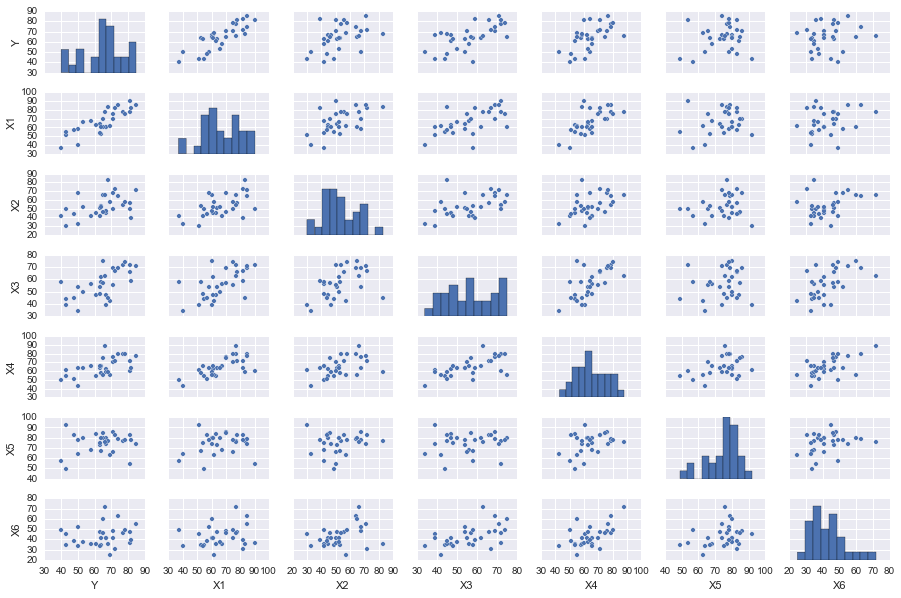

In [13]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(df, size = 1.2, aspect=1.5)

### Ordinary Least Squares Regression with Statsmodels
Now that we have a feel for our data, let's jump right in and try a basic regression model.  We will use the [***statsmodels.formula.api.ols***](http://statsmodels.sourceforge.net/devel/example_formulas.html) function to generate our model.  This type of model, along with other statsmodels linear models, takes as its parameters an [R formula](http://science.nature.nps.gov/im/datamgmt/statistics/r/formulas/) style formula for describing the inputs you want for your regression.  ***Statsmodels*** uses [***patsy***](http://patsy.readthedocs.org/en/latest/) to convert this syntax into the proper data matrices for input into its linear models under the covers.  There are a variety of interactions and functions of variables that you can incorporate with this syntax, so feel free to check out the docs.

Here we'll just start by defining a regression model that takes as its inputs each of the 6 predictor variables.  The other parameter of course is the data that the model is to be built from, our pandas dataframe.

In [14]:
# Define the model
lm = smf.ols('Y ~ X1 + X2 + X3 + X4 + X5 + X6', data=df)
# Fit the model
fit1 = lm.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Tue, 07 Jul 2015   Prob (F-statistic):           1.24e-05
Time:                        20:20:23   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.7871     11.589      0.931      0.362       -13.187    34.761
X1             0.6132      0.161      3.809      0.001         0.280     0.946
X2            -0.0731      0.136     -0.538      0.596        -0.354     0.208
X3             0.3203      0.169      1.901      0.070        -0.028     0.669
X4             0.0817      0.221      0.369      0.715        -0.376     0.540
X5             0.0384      0.147      0.261      0.796        -0.266     0.342
X6            -0.2171      0.178     -1.218      0.236        -0.586     0.152
==============================================================================
Omnibus:                        2.386   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                1.255
Skew:                          -0.081   Prob(JB):                        0.534
Kurtosis:                       2.011   Cond. No.                     1.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Regression Statistics
From this we get a handful of useful statistics describing our regression.  A quick google search on any should yield details for those interested.  We will focus on the ***R<sup>2</sup>*** values and the middle table here.

***R<sup>2</sup>*** is the square of the correlation coefficient and represents the estimated percentage of the variance in our target variable ***Y*** that can be explained by our regression model.  ***Adjusted R<sup>2</sup>*** also penalizes for things such as large coefficients and extra variables to try and limit ***overfitting*** so it is often a better measure of model efficacy.  We will use that here.

The middle table provides the **coefficients** that are regression has found, along with the **standard error** for each coefficient.  This defines our model, aka these are the model parameters that our algorithm was seeking to determine.  

The **t-scores** are values that the coefficients score in the [Student's T Distribution](https://en.wikipedia.org/wiki/Student's_t-distribution) and the **P(|t|)** field represents the probability of finding such a t-score if the actual value of the coefficient were 0.  In other words, if we had a coefficient whose true value should be 0 (aka the predictor has no impact on the response) then this P-value is the probability of finding such a coefficient value in our regression by random chance.  In essence, it measures our degree of belief that the coefficient for each variable should be zero.  Thus, the lowest P-values represent the most likely predictors to be impacting the response.

Putting it all together, the final column returns a **95% Confidence Interval** for the value of each coefficient.

Given these stats, lets remove the highest 3 P-values from our regression model, from ***X<sub>2</sub>***, ***X<sub>4</sub>***, and ***X<sub>5</sub>*** and see how our model performs now:

In [15]:
# Define the model
lm = smf.ols('Y ~ X1 + X3 + X6', data=df)
# Fit the model
fit2 = lm.fit()
# Check out the results
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     22.92
Date:                Tue, 07 Jul 2015   Prob (F-statistic):           1.81e-07
Time:                        20:23:42   Log-Likelihood:                -97.638
No. Observations:                  30   AIC:                             203.3
Df Residuals:                      26   BIC:                             208.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     13.5777      7.544      1.800      0.084        -1.929    29.084
X1             0.6227      0.118      5.271      0.000         0.380     0.866
X3             0.3124      0.154      2.026      0.053        -0.005     0.629
X6            -0.1870      0.145     -1.291      0.208        -0.485     0.111
==============================================================================
Omnibus:                        2.856   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                1.394
Skew:                          -0.121   Prob(JB):                        0.498
Kurtosis:                       1.972   Cond. No.                         605.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our **Adjusted R<sup>2</sup>** has increased, and our P-values are lower so we likely have a better model.  Let's just try removing ***X<sub>6</sub>*** to see if that might improve our model a little bit more.

In [16]:
# Define the model
lm = smf.ols('Y ~ X1 + X3', data=df)
# Fit the model
fit3 = lm.fit()
# Check out the results
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     32.74
Date:                Tue, 07 Jul 2015   Prob (F-statistic):           6.06e-08
Time:                        20:24:15   Log-Likelihood:                -98.569
No. Observations:                  30   AIC:                             203.1
Df Residuals:                      27   BIC:                             207.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      9.8709      7.061      1.398      0.174        -4.618    24.359
X1             0.6435      0.118      5.432      0.000         0.400     0.887
X3             0.2112      0.134      1.571      0.128        -0.065     0.487
==============================================================================
Omnibus:                        6.448   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                1.959
Skew:                          -0.041   Prob(JB):                        0.375
Kurtosis:                       1.751   Cond. No.                         503.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Nope, both **R<sup>2</sup>** coefficients decreased so lets stick with the 2nd model.

### Plotting Residuals
Before we call it a day with this model and dataset, let's take a quick look at a plot of our residuals *(actual value - predicted value)* with this model.  We do this because in a good model we essentially want our errors to be random.  If our residuals look systematic (e.g. missing high for one range and low for another) then we probably are missing the actual functional dependency underlying the data (perhaps it's not really linear).

Take a look [here]([a bad residue plot](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit) for an example of a bad residual plot.

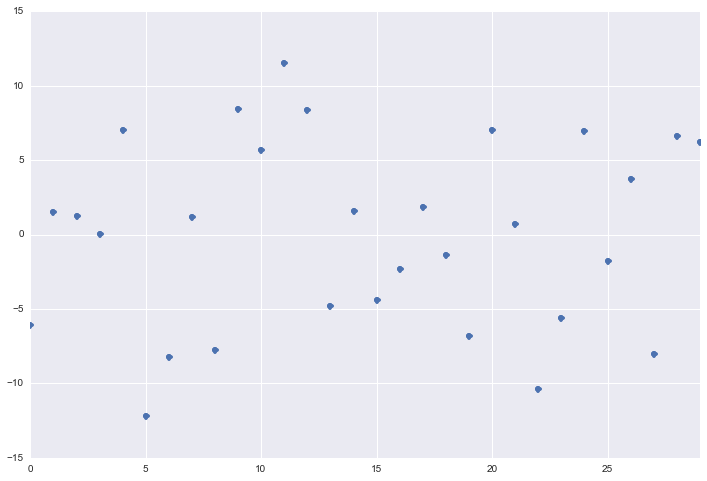

In [17]:
# Use statsmodels to plot the residuals
fit2.resid.plot(style='o', figsize=(12,8))

Nope this looks pretty random to me!  So let's move on to some more interesting modeling functions with sklearn!

## Regularized Regression and Polynomial Regression with sklearn
Statsmodels has decent functionality for linear models, but scikit-learn has a massive amount of modeling options for all sorts of algorithms as well as data preparation and is growing every day, so we will generally be working with that from here on.

### Regression with sklearn
Before we jump into some of the additional features of sklearn, let's try to repeat our basic survey example using sklearn's built in **LinearRegression**.

You should still have your Dataframe loaded from earlier.  Let's try repeating some of the different models we tried earlier with sklearn.  Here's the first model:

In [18]:
# Create an empty model
lr = LinearRegression()
# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df.iloc[:, 1:]
# Choose the response variable(s)
y = df.iloc[:, 0]
# Fit the model to the full dataset
lr.fit(X, y)
# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.7326019925311491

If you look back you'll notice that this is the same **R<sup>2</sup>** value that was reported for the first model above.  Let's quickly run the best model from earlier (***X1***, ***X3***, and ***X6***) and see how it performs.

In [19]:
# Create an empty model
lr = LinearRegression()
# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df.loc[:, ['X1', 'X3', 'X6']]
# Choose the response variable(s)
y = df.iloc[:, 0]
# Fit the model to the full dataset
lr.fit(X, y)
# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.72559499957450746

Notice that the **R<sup>2</sup>** value is the same again.  It's slightly lower, the same as we saw earlier, but the **Adjusted R<sup>2</sup>** value that we saw earlier was higher for this one.  

So we've seen how can do simple models with statsmodels and sklearn, but what does anyone see an issue with what we've done here?  What data have we fit and scored our models on?  What claims can we make about the probable performance of our model going forward?

### Regularized and Cross-Validated Regression
As you probably guessed, the problem with our model above was that we trained and tested our model on the same dataset.  This means our model could be very likely to **overfit** and not perform as well when it tries to **generalize** to real world data, and after all ***generalization is the key to machine learning***.

Thus, we have a need for **cross-validation** in our model evaluation process.  That is, we need to find a way to train our model on 1 randomly chosen set of data and evaluate it against a separate random test set.  Thankfully sklearn provides a bevy of built-in ways to perform cross-validation.

#### Cross-Validation with sklearn
The simplest way to perform cross-validation with an sklearn model is to have it perform a random **train/test split** of the data for you.  It's customary to use something like 2/3 of your data for training, and the remaining 1/3 for testing.  

sklearn's ***train_test_split*** function provides exactly that.  Here's an example of it in action.

In [22]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.70353835772005291

Notice that our model performance is significantly decreased.  This is **okay!**  In fact, this is better as we now have a much more accurate number to report regarding probable model performance in the real world, and we won't be making false promises to our CEO :)

There are a variety of ways to do cross-validation, and sklearn's modules for handling this can be found [here](http://scikit-learn.org/dev/modules/cross_validation.html).  We'll be seeing different methods as we continue in the course, but the basic 2-to-1 split is generally a safe fallback.

#### Regularized Regression with sklearn
As we've discussed, **regularization** is basically a blanket term for any technique that alters a model to prevent **overfitting**.  In linear regression, this is generally done by adding a term to the **Cost function** that is increasing in the absolute value of the coefficients.  The upshot of this is that models with large coefficients are implicitly punished by increasing their cost function, and the underlying mathematics of regression seek to choose the model that minimizes the value of the cost function.

There are 2 very common regularization techniques for regression, called **"Ridge Regression"** and **"Lasso Regression"**

##### Ridge Regression
[Ridge Regression](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) adds the L2 norm (square root of the sum of squares) of the coefficients to the cost function.

##### Lasso Regression
[Lasso Regression](http://scikit-learn.org/stable/modules/linear_model.html#lasso) adds the L1 norm (sum of absolute values) of the coefficients to the cost function.

sklearn has specific model types for both of the above regressions which we will see some of below.  Essentially, there is a "punishment parameter" alpha that these models try several different values of with cross-validation and then they return the value and model that yields the best generalization.  The beauty of this is that it all (optionally) happens completely under the covers!  We will use **RidgeCV** later in the exercises to perform regression with automatic Regularization and Cross-Validation.

### Polynomial Regression
So far we've only tried to create regression models that are linear functions of the predictor variables.  However, there's no reason we can't transform the predictor variables by any type of function we want before inputting them to linear regression.  This is the idea behind [**Polynomial Regression**](https://en.wikipedia.org/wiki/Polynomial_regression) and it allows us (along with similar functional regressions) to essentially model our response variables as any function of our predictor variables that we like.  Viewed in this way, Linear Regression is just a special instance of Polynomial Regression with a polynomial of degree 1.

#### Polynomial Regression with sklearn
sklearn has built-in options for converting your predictor variables to polynomial functions of them.  In this exercise we'll use the [**PolynomialFeatures**](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) class of sklearn to manipulate incoming predictors into nth-order polynomials of those features.  We'll combine this with the [***make_pipeline***](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) function to string together a pipeline of operations that is able to first transform our linear features into polynomial features and then run a linear regression against the resulting polynomial features. 

##### Generating Random Data
The first thing we're going to do is manufacture some data from a known distribution with a little additive noise.  This allows us to compare our results to the known ground truth.  Let's create that data from a sine curve as follows:

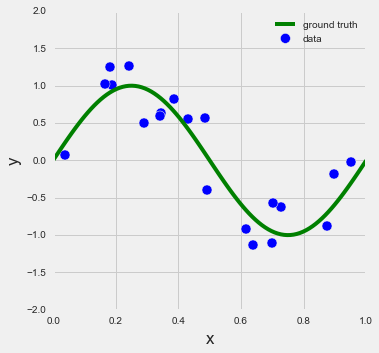

In [23]:
from IPython.core.pylabtools import figsize
figsize(5,5)
plt.style.use('fivethirtyeight')

# We start by seeding the random number generator so that everyone will have the same "random" results
np.random.seed(9)

# Function that returns the sin(2*pi*x)
def f(x):
    return np.sin(2 * np.pi * x)

# generate points used to plot
# This returns 100 evenly spaced numbers from 0 to 1
x_plot = np.linspace(0, 1, 100)

# generate points and keep a subset of them
n_samples = 100
# Generate the x values from the random uniform distribution between 0 and 1
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
# Generate the y values by taking the sin and adding a random Gaussian (normal) noise term
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]
# Split the data into a 20/80 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

# Plot the training data against what we know to be the ground truth sin function
fig,ax = plt.subplots(1,1)
ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
ax.scatter(X_train, y_train, label='data', s=100)
ax.set_ylim((-2, 2))
ax.set_xlim((0, 1))
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

##### Fitting an nth-degree Polynomial
Now that we have our data and know the ground truth, let's try fitting a 3rd degree polynomial to our training data and see how it looks.  3rd degree makes sense for this interval because the sin function has 2 turning points over the interval [0,1] and a 3rd degree polynomial will general have 2 (or less) turning points.

We first define a function `plot_approximation` that takes a pipeline of steps from make_pipeline and some plotting info and will plot the results of the sklearn pipeline on the specified plot with the ground truth and data in the background.

In [24]:
# import PolynomialFeatures and make_pipeline for Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X_train, y_train, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

Now let's generate our pipeline for a 3rd degree polynomial and try it out in our plotting function.  Not that the steps are:
- Use PolynomialFeatures(3) to create a generator of 3rd degree polynomials
- Feed this generator to make_pipeline along with a LinearRegression object to tell it to string together these operations when given a new set of input predictor variables.  This results in a new model object that has the same `fit()`, `score()`, `predict()`, etc functions
- Call `fit()` on our new object to fit a 3rd degree polynomial regression
- Send the result to our plotting function to view the results

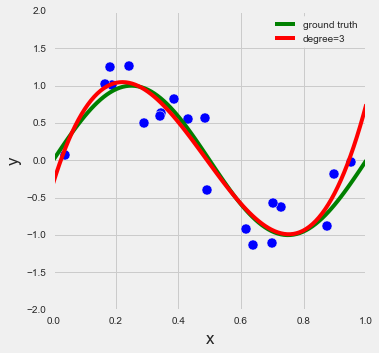

In [25]:
# Set up the plot
fig,ax = plt.subplots(1,1)
# Set the degree of our polynomial
degree = 3
# Generate the model type with make_pipeline
# This tells it the first step is to generate 3rd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# Fit our model to the training data
est.fit(X_train, y_train)
# Plot the results
plot_approximation(est, ax, label='degree=%d' % degree)

**Q: Qualitatively**, how would you characterize this fit?

### Your turn:
Plot the fit of a polynomial of degree 2:

Plot the fit of a polynomial of degree 9:

**Q: What happens as we increase the degree of polynomial?**

**Q: Which polynomial should we choose?**

To gain some insight into this, let's plot polynomials from degree 1 to 9 and examine how the errors in our predictions change vs. the training and test sets.

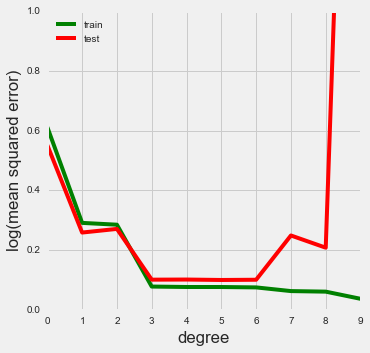

In [26]:
from sklearn.metrics import mean_squared_error

# Step through degrees from 0 to 9 and store the training and test (generalization) error.
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 1e0))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left')

**What do you notice?**

The higher the degree of the polynomial (our proxy for model complexity), the lower the training error. The testing error decreases too, but it eventually reaches its minimum at a degree of three and then starts increasing at a degree of seven. 

This is a visual demonstration of ***overfitting***: the model is already so complex that it fits the idiosyncrasies of our training data, idiosyncrasies which limit the model's ability to generalize (as measured by the testing error).

In the above example, the optimal choice for the degree of the polynomial approximation would be between three and six. So when we get some data, we could fit a bunch of polynomials and then choose the one that minimizes MSE.

### Hand picking polynomials is hard work, and data scientists are lazy so....
...we would like a method that eliminates the need to manually select the degree of the polynomial: we can add a constraint to our linear regression model that constrains the magnitude of the coefficients in the regression model. This constraint is called the regularization term and the technique is often called shrinkage in the statistical community because it shrinks the coefficients towards zero. In the context of polynomial regression, constraining the magnitude of the regression coefficients effectively is a smoothness assumption: by constraining the L2 norm of the regression coefficients we express our preference for smooth functions rather than wiggly functions.

A popular regularized linear regression model is Ridge Regression. This adds the L2 norm of the coefficients to the ordinary least squares objective:

  $J(\boldsymbol\beta) = \frac{1}{n}\sum_{i=0}^n (y_i - \boldsymbol\beta^T \mathbf{x}_i')^2 + \alpha \|\boldsymbol\beta\|_2$

where $\boldsymbol\beta$ is the vector of coefficients including the intercept term and $\mathbf{x}_i'$ is the i-th feature fector including a dummy feature for the intercept. The L2 norm term is weighted by a regularization parameter ``alpha``: if ``alpha=0`` then you recover the Ordinary Least Squares regression model. The larger the value of ``alpha`` the higher the smoothness constraint.

Below you can see the approximation of a [``sklearn.linear_model.Ridge``](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) estimator fitting a polynomial of degree nine for various values of ``alpha`` (left) and the corresponding coefficient loadings (right). The smaller the value of ``alpha`` the higher the magnitude of the coefficients, so the functions we can model can be more and more wiggly. 

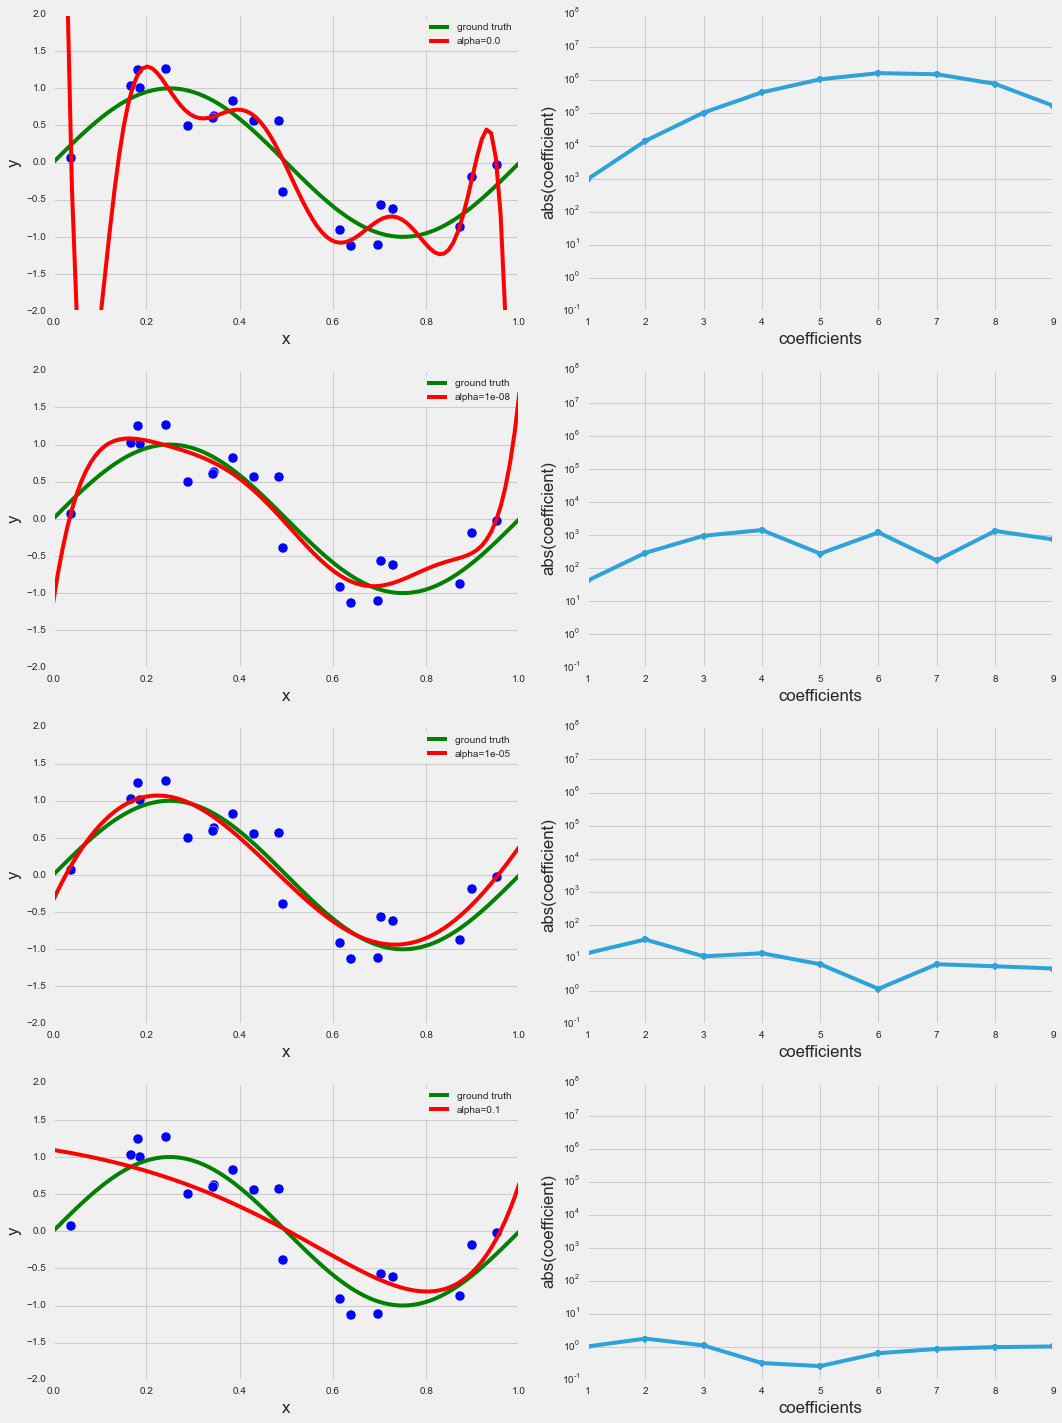

In [27]:
from sklearn.linear_model import Ridge

# Set up a figure and axes for 8 plots, 2 per row for 4 rows
fig, ax_rows = plt.subplots(4, 2, figsize=(15, 20))

# A helper function to plot the absolute value of the coefficients on the right-hand column plot
def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((1, 9))

# Try out 4 different values of the RidgeRegression parameter alpha and watch how the resulting models change
# With higher values of alpha, more complex (more wiggly) models will be more punished and thus less likely
degree = 9
alphas = [0.0, 1e-8, 1e-5, 1e-1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)

plt.tight_layout()

## Regularization techniques

In the above example we used Ridge Regression, a regularized linear regression technique that puts an [L2 norm](http://mathworld.wolfram.com/L2-Norm.html) penalty on the regression coefficients. As mentioned above, another popular regularization technique is the LASSO, a technique which puts an [L1 norm](http://mathworld.wolfram.com/L1-Norm.html) penalty instead. The difference between the two is that the LASSO leads to sparse solutions, driving most coefficients to zero, whereas Ridge Regression leads to dense solutions, in which most coefficients are non-zero.

Let's check out the same process using the LASSO:

/Users/pburkard88/anaconda/envs/python27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


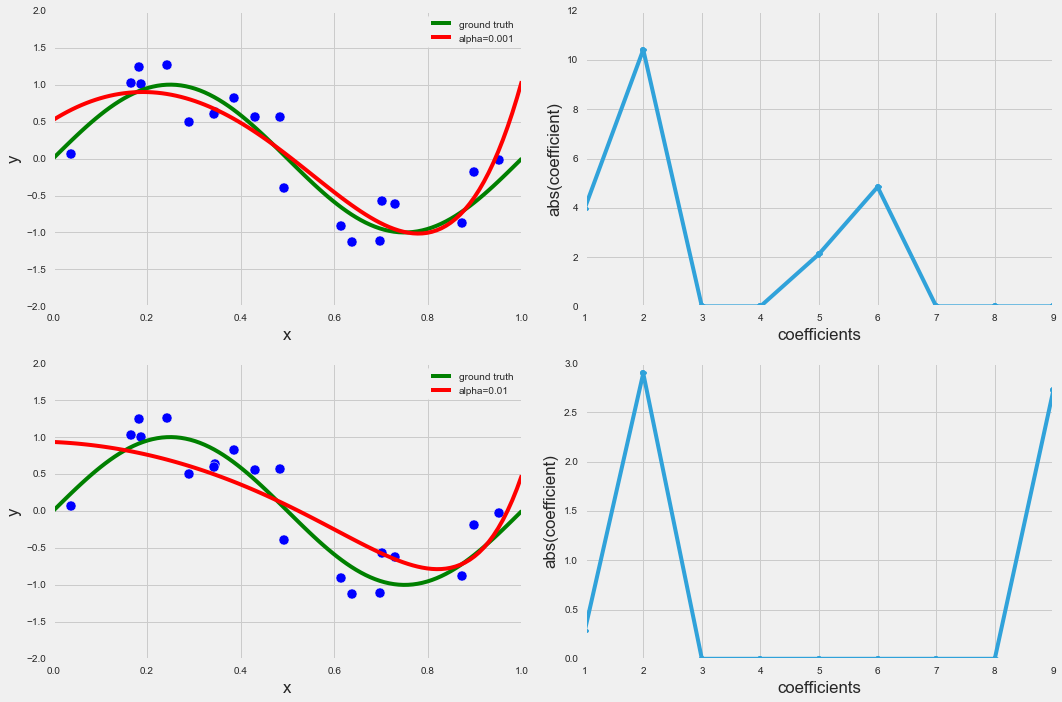

In [28]:
from sklearn.linear_model import Lasso

# Create only 2 plot rows, only trying 2 alphas
fig, ax_rows = plt.subplots(2, 2, figsize=(15, 10))

# Plot the results next to the coefficient values for each of hte 2 alphas
degree = 9
alphas = [1e-3, 1e-2]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Lasso(alpha=%r) coefficients' % alpha, yscale=None)

plt.tight_layout()

Notice that for the Lasso many of the coefficients are zero.  When you choose an sklearn model that encapsulates both Regularization and Cross-Validation (like [**RidgeCV**](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) to be used below for instance) sklearn will choose the best value from several options of ***alpha*** by cross-validating in whatever way you decide.

## Exercises: Bike Sharing Dataset
For these exercises we'll be exploring the Bike Sharing Dataset available [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).  The goal is to be able to predict the count of bikes being used at any given time given data on the time of day, year, week, weather conditions etc.

#### Data Exploration
##### Read the data in
The field descriptions are available at the link, and the data has been placed on the repo for you.  Make sure the "hour.csv" file is somewhere on your local machine, and then initialize the `path_to_data` variable below.  Use pandas `read_csv()` to load the data into a dataframe and then call `head()` to make sure everything looks good.

In [1]:
# Set the root location where the data is stored
path_to_data = '~/git/GA/Data Science/DS_BOS_07/Data/Bike-Sharing-Dataset/hour.csv'
# Read in the bike data

# Use head to view the first few rows


Use `shape` to check out how many rows and columns the dataframe has.

In [ ]:
# How many rows and columns do we have?  You should see 17379 x 17


Use `info()` to get a summary of the dataframe and its datatypes

In [ ]:
# Let's examine the datatypes


**Remove** the **non-numeric columns** and the **instant column** (not useful for now) as well as the **atemp column** (because it is going to be almost perfectly correlated with temp) and the **casual and registered columns** (because they would make things too easy :)).  Do this by:
- Create a list of columns to keep
- Select out only those columns from the dataframe and reassign the dataframe to that selection
- Use `head()` to make sure everything worked as expected

In [ ]:
# Create a list of columns to keep

# Select out only those columns

# Use head to review the remaining data, you should now have 12 columns


Before we begin modeling, use the `corr()` function to get a feel for the correlations among the different variables, especially with regard to 'cnt'.

In [ ]:
# Check out the dataframe correlations with corr()


Take a look at only the 'cnt' column of the correlations and order it in descending order wih `order()`

In [ ]:
# Get the correlations with 'cnt' sorted in descending order


You should now have a better feel for which variables might be most valuable for your model.

Now use ***seaborn's*** `pairplot()` function to visualize these correlations for the variables ***mnt, season, hr, temp, hum, and cnt***.  Do any of the distributions jump out at you at all?

In [ ]:
# Let's try visualizing some of these pairwise correlations with seaborn


#### Modeling with statsmodels
Let's try some exploration with statsmodels.  As a first model, try creating an ordinary least squares model with statsmodels by incorporating all of the variables that had at least a .10 absolute value of correlation with cnt above (**HINT:** this should be 7 variables).
- Create your model with the `ols()` function with the appropriate **R Formula** syntax and your dataframe
- Fit the model
- Print the fit summary to check out the results

In [ ]:
# Let's jump right in and try a model with statsmodels using all variables above .10 correlation
# Use ols() to create your model

# Call fit() to fit your model

# Call summary() to see how you did


#### Seaborn for Exploring Distributions
Your **R<sup>2</sup>** should be .386, not great.  That means we believe we can explain only about 38.6% of the variance in count with this model.  Let's use seaborn to explore a few of the relationships between the predictors and response in more detail.

Use the **seaborn** `boxplot()` function to create a boxplot of **temp** vs **count**.  **NOTE:** Make sure that the temp values are ordered by increasing temperature!  What are some things you notic about the relationship between temperature and count?

In [ ]:
# Let's visualize some of the different variables against 'cnt'
# Temp
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('Counts by Temperature')
# Create a seaborn boxplot of count by temperature ordered by temperature

ax.set_xlabel('Temp')
ax.set_ylabel('Count')

Create similar boxplots for the humidity, month, year, and season variables.  Take note of any relationships that jump out at you from the plots.

In [ ]:
# Humidity
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('Counts by Humidity')
# Create a seaborn boxplot of counts by humidity ordered by increasing humidity

ax.set_xlabel('Humidity')
ax.set_ylabel('Count')

In [ ]:
# Year
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('Counts by Year')
# Create a seaborn boxplot of counts by year ordered by increasing year

ax.set_xlabel('Year')
ax.set_ylabel('Count')

In [ ]:
# Month
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('Counts by Month')
# Create a seaborn boxplot of counts by month ordered by increasing month

ax.set_xlabel('Month')
ax.set_ylabel('Count')

In [ ]:
# Season
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('Counts by Season')
# Create a seaborn boxplot of counts by season ordered by increasing season

ax.set_xlabel('Season')
ax.set_ylabel('Count')

#### Incorporating nonlinear relationships in statsmodels
From your plots, you should clearly notice that month and season do not have a linear relationship with count.  Try to create a statsmodels model that incorporates this.
- Define the model using the `ols()` function and the proper R formula and data
- Use the syntax `var_name^power` in your R formula to add features for mnth^2, mnth^3, mnth^4 and likewise for season.  This is akin to polynomial regression on those variables with a 4th degree polynomial.  Make sure to retain all of the linear variables from your original regression except **exclude weathersit** for this one.
- Call the `fit()` function to fit your model
- Call the `summary()` function to view how your model did

In [ ]:
# Define your model with the appropriate R formula and ols()

# Call fit on your model

# Call summary to print how you did


You should see a slight improve in your **Adjusted R<sup>2</sup>** but not too much to get excited about.  So let's focus on the **hr** column now.

Use **seaborn** again to make a boxplot of counts by hour as you did for the other variables above.

In [ ]:
# Hour
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('Counts by Hour')
# Create a seaborn boxplot of counts by hour ordered by increasing hour

ax.set_xlabel('Hour')
ax.set_ylabel('Count')

You should see that hour is clearly not linearly related to count either.  So try altering your statsmodels model to incorporate a 4th degree relation with hr as well.
- Use `ols()` with everything you had before plus the appropriate 4 **hr** terms to define your model
- Call `fit()` on your model
- Call `summary()` to print how you did

In [ ]:
# Define your model with the appropriate R formula and ols()

# Call fit on your model

# Call summary to print how you did


You should see your **R<sup>2</sup>** up to .470 now, but this is a very complex model so we could potentially be overfitting.  So let's try to trim the fat, starting with the month variable.  The mnth^3 term should have the highest P-value and thus be a candidate for removal.  Do just that and then re-evaluate your model.
- Create a new model with `ols()` that's the same as the last one minues the **mnth^3** term
- Use `fit()` to fit your model
- Use `summary()` to print the results

In [ ]:
# Use ols to create a model the same as the last minus mnth^3

# Use fit to fit the model

# Use summary to see how you did


Well now, if you did it correctly this is nice now.  Almost all of the P-values are essentially 0 except for **season**.  So as one last iteration try removing season from your model.
- Use `ols()` to create a model the same as the last one minus the **season** term
- Call `fit()` to fit your model
- Call `summary()` to print a summary of how you did

In [ ]:
# Use ols to create the same model minus season

# Call fit to fit your model

# Call summary to print results


Alright not bad, we can explain almost half of the data's variance and all of the coefficients claim to be very decidedly nonzero.  But how do we know how it will perform against a test set?

Finally we get to move on to sklearn with this dataset.

### sklearn, Cross-Validation and Regularization

If not already done, import sklearn.linear_model.LinearRegression and sklearn.cross_validation.train_test_split

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

Generate a features data matrix `X` by selecting out only the predictor variables (columns 1-11) from your dataframe and a response vector `y` by selecting only the last column (the cnt colum).  Use `iloc` to get these slices from your pandas dataframe.

In [ ]:
# Separate out our predictor variables from our reponse variables
# Dump your predictors into X

# Dump your target variables (responses) into y


Use the `train_test_split()` function on `X` and `y` to generate a 70/30 train/test spilt of your data.  Put these splits into `X_train`, `X_test`, `y_train`, and `y_test`.

In [ ]:
# Let's generate a 70/30 train/test split


Create a `LinearRegression` object, train it on `X_train` and `y_train` by calling `fit()`, and then print out the performance against the test set by calling `score()` on `X_test` and `y_test`.

In [ ]:
# Create the model

# Call fit

# Call score


#### What have we done?
We've created a model akin to our first model in statsmodels.  It's a completely linear model and performs similarly, although this time we can state our performance with confidence because we have performed **cross-validation**, aka we've trained on one set and tested on a different one.  Thus, we have belief that this model can generalize with that performance.

From here we could proceed to try out some of the polynomical models that we used with statsmodels above.  However, if you remember the distribution of the counts by **hours** from above, you might be thinking it could be more fruitful to investigate that variable a little more and in a smarter way.  If so, congratulations!  You're on your way to becoming a good data scientist!

#### Reexamining Hours
Use seaborn again to generate the boxplot of counts by hour again, for reference.  Since you've presumably already done this, it has been filled in for you.

In [ ]:
# Let's examine the hours more closely
# Hour
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('Counts by Hour')
sns.boxplot(x=df['hr'].order(), y=df['cnt'])
ax.set_xlabel('Hour')
ax.set_ylabel('Count')

#### What do you notice?
The key observation here is (to this author at least), there seems to be 3 distinct classes of traffic during the day:  
1. The low-traffic night hours  
2. The high-traffic peak commute hours  
3. The middle-traffic daytime hours

#### What can we do with this observation?
##### Indicator (Dummy) Variables
As a first attempt, let's try to create [***indicator variables***](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) `hr_low`, `hr_high`, and `hr_med` that represent the 3 traffic situations described above.  Indicator variables are 0/1 binary variables that indicate whether a condition is met or not, and they are quite useful in regression as they have an easy conceptual understanding: a value of 1 for a given field increases the target variable by the amount of its model coefficient.  These are often useful when provided with categorical attributes.  Any field with n unique categorical values can be reformulated into n indicator variable fields where each represents whether or not that attribute value is present.

So let's use indicator variables for the hours to classify low, medium, and high traffic times.  To do this:
- Generate additional columns of your dataframe called `hr_low`, `hr_med`, and `hr_high` and initialize them to 0
- For each column, replace the column with a call to `map()` on the dataframe's **hr** column
- This `map()` should call a `lambda` function that returns 1 if the **hr** is in the list of hours values for that particular traffic group (as judged by your own observation of the boxplot above) and 0 otherwise
- Call `head(24)` to make sure the results make sense for an entire day's worth of hours

In [ ]:
# Create the 3 new columns initialized to 0
# You can do this the same way you might add a new entry to a Dict



# Apply map to the hr column to generate the values in each of the 3 new columns



# Call head(24) to check everything is in order


#### What have we done?
We have some new variables in our dataframe now.  Let's take a look at all of the correlations to **cnt** now.
- Use `corr()` to retrieve all correlations
- Select out only the **cnt** column
- Use `order()` to sort them in descending order

In [ ]:
# Let's take a look at the correlations of our new variables


This looks quite promising, our new variables are quite strongly correlated with **cnt**.

Now, finally let's try tossing out the **hr** column and use our 3 newly defined columns in its place.  Let's use those along with our original 6 other attributes to generate a new `LinearRegression` model with `sklearn`.  
- Generate a data matrix `X` by selecting out the fields `hr_low`, `hr_med`, `hr_high`, `temp`, `hum`, `weathersit`, `windspeed`, `season`, `workingday`.  Use `loc` for this.
- Generate a target variables vector `y` by selecting out just the `cnt` column.
- Use `train_test_split()` to generate `X_train`, `X_test`, `y_train`, `y_test` with a 70/30 split
- Fit your model with `fit()` against `X_train` and `y_train`
- Score your model against `X_test` and `y_test` with `score()`

In [ ]:
# This is promising, both the hr_high and hr_low have stronger correlations than any from before
# Let's try building another model with this new information
# Generate X

# Generate y

# Generate 70/30 training and test sets

# Call fit

# Call score


#### What happened?
Well, this is awesome!  With just a slightly deeper understanding of the hours distribution we've made a marked improvement in our model (you should now see a score around .57).

### Automatic Cross-Validation with sklearn
So far we've just been using train/test splits for cross-validation and we haven't let sklearn do the work for us.  We also haven't even touched regularization.  So here we're going to do both, and we're going to do it in just 3 lines!

First, import sklearn.linear_model.RidgeCV

In [ ]:
from sklearn.linear_model import RidgeCV

Now, create a `RidgeCV` object with the parameter `cv` set to 10.  

What this will do is perform [10-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation).  The CV in RidgeCV means that is has this capability built in.  Because this is a Ridge Regressor, it also has regularization built in.  You can check out the [RidgeCV Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) to see the default values it uses for `alpha` (they are configurable as a parameter of course).

In [ ]:
# Create the model with cv=10


Now do the following:
- train your model on the entire dataset `X` and `y` from above via `fit()` (we can do this because we have built-in cross-validation)
- Score the model with `score()`.  You should see a similar score to the one you got with the train/test split.

In [ ]:
# Call fit

# Call score


So, awesome!  With just a little variable manipulation we've already improved our baseline model by about 50% and with cross-validation and regularization we have an estimate of our model's future performance that we should feel reasonably comfortable reporting to our boss.

Now one last thing to try to squeeze out a little bit more performance.  If you're thinking like a data scientist, you'll probably imagine that the bike traffic by hour will be very different on workdays vs. non-workdays.  Fortunately, we have the data available to test this hypothesis!

Let's generate 2 boxplots of Bike Counts by hour with seaborn, the first one for workdays and the 2nd one for non-workdays.  To do this:
- Select the rows where workingday==1 from your dataframe, and use that resulting dataframe to build your boxplot as you did many times above
- Do the same for workingday==0 for the second plot
- Analyze your results

In [ ]:
# With just a little consideration of the data we've improved our baseline model about 50%
# Let's look just a little further at hours
# For when workday = 1 vs 0
# Set up the plots
fig, axes = plt.subplots(2,1, figsize=(20,10))
ax = axes[0]
ax.set_title('Counts by Hour on Workdays')
# Generate your workingday boxplot here

ax.set_xlabel('Hour')
ax.set_ylabel('Count')
ax = axes[1]
ax.set_title('Counts by Hour on Non-Workdays')
# Generate your non-workingday boxplot here

ax.set_xlabel('Hour')
ax.set_ylabel('Count')


### What do you notice?
You should notice that the 2 distributions are **completely** different.  On non-workdays the middle of the day hours have far more traffic (as one would expect) and the peak commute hours have low traffic.  Thus, it appears that our hypothesis has been shown correct.

#### How can we use this?
It appears from this that we have 2 fundamentally different distributions of the data.  Perhaps we could use this to split the data along the workingday value and build 2 different models (1 for workdays and 1 for non-workday).  To get a feel for how such a model might do, let's try it on the workdays only (because this distribution looks very similar to the overall one we looked at earlier, we can use the hour indicator variables that we already created for convenience).

Let's train a model for workdays only using the same variables we used for our last model and take a look at the results.
- Generate the data matrix `X` by selecting the columns `hr_low`, `hr_med`, `hr_high`, `temp`, `hum`, `weathersit`, `windspeed`, `season`, and `workingday`
- Select only those rows of `X` where workingday==1 and store this result in `X`
- Select the rows of the `cnt` column where workingday==1 and store this result in `y`
- Use `train_test_split()` to create a 70/30 split in `X_train`, `X_test`, `y_train`, `y_test`
- Create a basic `LinearRegression` model
- Call `fit()` to fit your model on the training data
- Call `score()` against the test data to view your results

In [ ]:
# These are clearly 2 very different distributions!  
# Maybe want to consider these 2 situations separately and build a model for each
# Let's just take a quick look for workingday = 1
# Generate X


# Generate y

# Generate training and test 70/30 split

# Create model

# Call fit

# Call score


## Holy smokes we're getting better!
If you did it right, you should see another significant improvement.  Hopefully this exercise as shown how the iterative data science pipeline can lead to incrementally better results over time.

## What have we done?
- Learned how to use statsmodels with R formula syntax for creating linear models
- Learned how to evaluate models in different ways (R^2, cross-validation)
- Learned some ways to avoid overfitting (cross-validation, regularization)
- Understood linear and polynomial regression in sklearn, with cross-validation and regularization
- Used seaborn for visualizing relationships in data
- Used pandas for manipulating data as we move through our workflow
- Gotten a peak into a genuine data science workflow
- Seen how curiosity and creativity can yield big gains in a data science modeling pipeline

## Play Time
See if you can improve the model by trying out whatever methods you like!  Just be sure to cross-validate!